## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix , roc_curve, auc , classification_report , roc_auc_score
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications.convnext import preprocess_input # This function actually does nothing but I kept it anyways

import zipfile
import shutil

from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
import statsmodels.stats.multitest

np.random.seed(123)

In [3]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.13.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Unzip files
After downlaoding from Harvard data website, we will unzip the files. Only need to do this once, but we kept the unzipping function for future use just in case.

In [4]:
source_path = "/content/drive/MyDrive/Colab_Notebooks/HAM10000/"

In [5]:
def unzip_zip_file(zip_filepath, extract_to):
    try:
        # Open the SIP file in read mode
        with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
            # Extract all contents to the specified location
            zip_ref.extractall(extract_to)
        print(f"Successfully unzipped {zip_filepath} to {extract_to}")
    except Exception as e:
        print(f"Error unzipping {zip_filepath}: {str(e)}")


In [6]:
part_1_zip_filepath = source_path+"HAM10000_images_part_1.zip"
part_2_zip_filepath = source_path+"HAM10000_images_part_2.zip"
extract_folder = source_path+"HAM10000_images"

In [7]:
# unzip_zip_file(part_1_zip_filepath, extract_folder)
# unzip_zip_file(part_2_zip_filepath, extract_folder)

## Load Data

In [8]:
def load_df():
    image_locations = itemize_images()
    metadata_df = pd.read_csv(source_path+"HAM10000_metadata.csv")
    metadata_df['filepath'] = metadata_df['image_id'].map(image_locations)
    return metadata_df


def itemize_images():
    images_location = source_path+'HAM10000_images/'
    itemized_dict = {}
    for image in os.listdir(images_location):
        itemized_dict[image.replace(".jpg", "")] = images_location + image
    return itemized_dict


In [9]:
metadata_df = load_df()
metadata_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,filepath
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Colab_Notebooks/HAM1000...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Colab_Notebooks/HAM1000...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Colab_Notebooks/HAM1000...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Colab_Notebooks/HAM1000...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,/content/drive/MyDrive/Colab_Notebooks/HAM1000...
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,/content/drive/MyDrive/Colab_Notebooks/HAM1000...
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,/content/drive/MyDrive/Colab_Notebooks/HAM1000...
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,/content/drive/MyDrive/Colab_Notebooks/HAM1000...
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,/content/drive/MyDrive/Colab_Notebooks/HAM1000...


## Train-Test Split
We will split by lesion ID to avoid leakage.

In [10]:
train_dir = source_path+"train/"
test_dir = source_path+"test/"
val_dir = source_path+"validation/"

In [11]:
df_count = metadata_df.groupby('lesion_id').count().reset_index()

In [12]:
train_df , test_df = train_test_split(df_count, test_size=0.2)
val_df , test_df = train_test_split(test_df, test_size=0.5)

In [13]:
def get_data_set(x , test_dataframe=test_df , val_dataframe=val_df):
  test_data = set(test_dataframe['lesion_id'].to_list())
  val_data = set(val_dataframe['lesion_id'].to_list())
  if str(x) in test_data:
    return "test"
  elif str(x) in val_data:
    return "validation"
  else:
    return "train"

In [14]:
metadata_df["train_test_val"] = metadata_df['lesion_id'].apply(get_data_set)
train_df = metadata_df[metadata_df["train_test_val"] == "train"]
validation_df = metadata_df[metadata_df["train_test_val"] == "validation"]
test_df = metadata_df[metadata_df["train_test_val"] == "test"]

In [15]:
metadata_df["pic_filename"] = metadata_df["image_id"] + ".jpg"
metadata_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,filepath,train_test_val,pic_filename
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Colab_Notebooks/HAM1000...,train,ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Colab_Notebooks/HAM1000...,train,ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Colab_Notebooks/HAM1000...,train,ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Colab_Notebooks/HAM1000...,train,ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,/content/drive/MyDrive/Colab_Notebooks/HAM1000...,train,ISIC_0031633.jpg
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,/content/drive/MyDrive/Colab_Notebooks/HAM1000...,train,ISIC_0033084.jpg
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,/content/drive/MyDrive/Colab_Notebooks/HAM1000...,train,ISIC_0033550.jpg
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,/content/drive/MyDrive/Colab_Notebooks/HAM1000...,train,ISIC_0033536.jpg
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,/content/drive/MyDrive/Colab_Notebooks/HAM1000...,validation,ISIC_0032854.jpg


Copy the files to train, test and validation folders.
Only need to so this once.

In [16]:
def copy_files_to_designated_dirs():
    not_copied = 0

    for index, row in metadata_df.iterrows():
        source_path = row['filepath']

        if row['train_test_val'] == 'train':
            destination_path = os.path.join(train_dir, row["dx"], row['pic_filename'])
        elif row['train_test_val'] == 'validation':
            destination_path = os.path.join(val_dir, row["dx"], row['pic_filename'])
        elif row['train_test_val'] == 'test':
            destination_path = os.path.join(test_dir, row["dx"], row['pic_filename'])

        if not os.path.exists(destination_path):
            if os.path.abspath(source_path) != os.path.abspath(destination_path):
                try:
                    shutil.copy(source_path, destination_path)
                except:
                  print("Error for " , source_path , " , ", destination_path)


In [17]:
#copy_files_to_designated_dirs()

Check that all files were copied:

In [18]:
def count_files_recursively(directory_path):
    file_list = []

    for root, dirs, files in os.walk(directory_path):
        for file in files:
            file_list.append(os.path.join(root, file))

    return len(file_list)

In [19]:
len(os.listdir(extract_folder))

10015

In [20]:
num_of_train_files = count_files_recursively(train_dir)
num_of_val_files = count_files_recursively(val_dir)
num_of_test_files = count_files_recursively(test_dir)

In [21]:
num_of_train_files + num_of_val_files + num_of_test_files

10015

They are the same length, which means everything was copied.
Number of samples in each:

In [22]:
print(num_of_train_files , num_of_val_files , num_of_test_files)

8064 983 968


Load files to the disk for faster runtimes

In [23]:
def create_images_folder():
    # Delete existing folder
    if os.path.exists("images"):
        shutil.rmtree("images")
        print("images has been deleted.")
    else:
        print("images does not exist.")

    try:
      os.mkdir("images")
      print("Folder 'images' created successfully")
    except FileExistsError:
        print(f"Folder 'images' already exists")
    except Exception as e:
        print(f"An error occurred: {e}")

def copy_folder(source_folder, destination_folder):
    try:
        # Use shutil.copytree to recursively copy the source folder to the destination folder
        shutil.copytree(source_folder, destination_folder)
        print(f"Folder '{source_folder}' copied to '{destination_folder}' successfully.")
    except Exception as e:
        print(f"An error occurred: {e}")

create_images_folder()
copy_folder(train_dir, "images/train/")
copy_folder(val_dir, "images/validation/")
copy_folder(test_dir, "images/test/")

images does not exist.
Folder 'images' created successfully
Folder '/content/drive/MyDrive/Colab_Notebooks/HAM10000/train/' copied to 'images/train/' successfully.
Folder '/content/drive/MyDrive/Colab_Notebooks/HAM10000/validation/' copied to 'images/validation/' successfully.
Folder '/content/drive/MyDrive/Colab_Notebooks/HAM10000/test/' copied to 'images/test/' successfully.


Check that it worked

In [24]:
print(count_files_recursively("images/train/") , count_files_recursively("images/validation/") , count_files_recursively("images/test/"))

8064 983 968


Update the filepath

In [25]:
metadata_df["filepath"] = "images" +  "/" + metadata_df["train_test_val"] + "/" + metadata_df["dx"] + "/" + metadata_df['pic_filename']
metadata_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,filepath,train_test_val,pic_filename
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,images/train/bkl/ISIC_0027419.jpg,train,ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,images/train/bkl/ISIC_0025030.jpg,train,ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,images/train/bkl/ISIC_0026769.jpg,train,ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,images/train/bkl/ISIC_0025661.jpg,train,ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,images/train/bkl/ISIC_0031633.jpg,train,ISIC_0031633.jpg
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,images/train/akiec/ISIC_0033084.jpg,train,ISIC_0033084.jpg
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,images/train/akiec/ISIC_0033550.jpg,train,ISIC_0033550.jpg
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,images/train/akiec/ISIC_0033536.jpg,train,ISIC_0033536.jpg
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,images/validation/akiec/ISIC_0032854.jpg,validation,ISIC_0032854.jpg


## Data imputation
Fill null values by mean value for each gender.

In [26]:
def metadata_imputation(df):

  # Find columns with null values:
  null_columns = df.columns[df.isnull().any()]
  print("Columns with null values: ", null_columns.values)

  # Only age has null values.

  # Fill null values with mean age for sex:
  mean_age_by_sex = df.groupby('sex')['age'].mean()

  print("\nMean age by sex: \n",  mean_age_by_sex)

  mean_age_males = mean_age_by_sex["male"]
  mean_age_females = mean_age_by_sex["female"]
  mean_all_values = df['age'].mean()

  # We will fill unknowns with the general mean because we think the unknown tag
  # may be biased: it is much younger.than the other group means.

  df['age'] = df.apply(lambda row: mean_age_males if (row['sex'] == 'male' and pd.isna(row['age'])) else (mean_age_females if (row['sex'] == 'female' and pd.isna(row['age'])) else row['age'])  , axis=1)
  df['age'].fillna(mean_all_values, inplace=True)


  print("\nFilled null values.")

In [27]:
metadata_imputation(metadata_df)

Columns with null values:  ['age']

Mean age by sex: 
 sex
female     48.711522
male       54.545370
unknown    37.500000
Name: age, dtype: float64

Filled null values.


## Preprocessing

### One hot encoding for categorial columns

We will do one-hot encoding for the categorial columns, inculding the labels.


In [28]:
exclude_values = ['unknown']

# For sex and localization columns: create one-hot encoding columns for all values except "unknown"
location_one_hot_encoding = pd.get_dummies(metadata_df['localization']).drop(exclude_values, axis=1)
sex_one_hot_encoding = pd.get_dummies(metadata_df['sex']).drop(exclude_values, axis=1)
# label_one_hot_encoding = pd.get_dummies(metadata_df['dx'])
metadata_df = pd.concat([metadata_df,sex_one_hot_encoding, location_one_hot_encoding], axis=1)

metadata_df = metadata_df.drop(columns=["localization" , "sex"])
metadata_df

,lesion_id,image_id,dx,dx_type,age,dataset,filepath,train_test_val,pic_filename,female,...,ear,face,foot,genital,hand,lower extremity,neck,scalp,trunk,upper extremity
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,vidir_modern,images/train/bkl/ISIC_0027419.jpg,train,ISIC_0027419.jpg,0,...,0,0,0,0,0,0,0,1,0,0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,vidir_modern,images/train/bkl/ISIC_0025030.jpg,train,ISIC_0025030.jpg,0,...,0,0,0,0,0,0,0,1,0,0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,vidir_modern,images/train/bkl/ISIC_0026769.jpg,train,ISIC_0026769.jpg,0,...,0,0,0,0,0,0,0,1,0,0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,vidir_modern,images/train/bkl/ISIC_0025661.jpg,train,ISIC_0025661.jpg,0,...,0,0,0,0,0,0,0,1,0,0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,vidir_modern,images/train/bkl/ISIC_0031633.jpg,train,ISIC_0031633.jpg,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,vidir_modern,images/train/akiec/ISIC_0033084.jpg,train,ISIC_0033084.jpg,0,...,0,0,0,0,0,0,0,0,0,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,vidir_modern,images/train/akiec/ISIC_0033550.jpg,train,ISIC_0033550.jpg,0,...,0,0,0,0,0,0,0,0,0,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,vidir_modern,images/train/akiec/ISIC_0033536.jpg,train,ISIC_0033536.jpg,0,...,0,0,0,0,0,0,0,0,0,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,vidir_modern,images/validation/akiec/ISIC_0032854.jpg,validation,ISIC_0032854.jpg,0,...,0,1,0,0,0,0,0,0,0,0


In [29]:
metadata_df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'dataset', 'filepath',
       'train_test_val', 'pic_filename', 'female', 'male', 'abdomen', 'acral',
       'back', 'chest', 'ear', 'face', 'foot', 'genital', 'hand',
       'lower extremity', 'neck', 'scalp', 'trunk', 'upper extremity'],
      dtype='object')

## Create input and target matrices


Notice that the input for the model will include:

*   The image
*   The metadata: age, gender columns and location columns.


We will define layers for image processing, Define a separate branch for processing metadata and finally combine the two branches using concatenation.

In [30]:
input_cols = ["filepath" , "age" , "male" , "female" , 'abdomen', 'acral', 'back', 'chest', 'ear', 'face', 'foot', 'genital', 'hand', 'lower extremity', 'neck', 'scalp', 'trunk','upper extremity']
target_cols = ["dx"] # ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [31]:
X_train = metadata_df[metadata_df["train_test_val"] == "train"][input_cols].reset_index(drop=True)
y_train = metadata_df[metadata_df["train_test_val"] == "train"][target_cols].reset_index(drop=True)

X_validate = metadata_df[metadata_df["train_test_val"] == "validation"][input_cols].reset_index(drop=True)
y_validate = metadata_df[metadata_df["train_test_val"] == "validation"][target_cols].reset_index(drop=True)

X_test = metadata_df[metadata_df["train_test_val"] == "test"][input_cols].reset_index(drop=True)
y_test = metadata_df[metadata_df["train_test_val"] == "test"][target_cols].reset_index(drop=True)

For example: look at the first 3 samples in the training data:


*   We have the resized image pixel values.
*   We have the age column.
*   We have one-hot-encoding columns for gender and location. Notice that if a gender/location value is unknown, it will get 0 in all one-hot columns. We did not create columns for the unknown values in order for the columns not to be linearly dependent on eachother.



Seperate image from metadata:

In [32]:
X_train_image = X_train[["filepath"]]
X_train_metadata = X_train.drop(columns=["filepath"])

X_validate_image = X_validate[["filepath"]]
X_validate_metadata = X_validate.drop(columns=["filepath"])

X_test_image = X_test[["filepath"]]
X_test_metadata = X_test.drop(columns=["filepath"])

## Normalization of Metadata
Notice that we normalize on train data only.
We chose to only normalize the metadata.

In [33]:
# Train scaler
scaler = preprocessing.StandardScaler().fit(X_train_metadata)

In [34]:
metadata_cols = X_train_metadata.columns

In [35]:
# Apply scale
X_train_metadata_scaled = pd.DataFrame(scaler.transform(X_train_metadata) , columns=metadata_cols)
X_validate_metadata_scaled =  pd.DataFrame(scaler.transform(X_validate_metadata) , columns=metadata_cols)
X_test_metadata_scaled =  pd.DataFrame(scaler.transform(X_test_metadata) , columns=metadata_cols)

In [36]:
# Merge image, metadata and label for future use
preprocessed_train = pd.concat([X_train_image, X_train_metadata_scaled, y_train], axis=1)
preprocessed_validate = pd.concat([X_validate_image, X_validate_metadata_scaled, y_validate], axis=1)
preprocessed_test = pd.concat([X_test_image, X_test_metadata_scaled, y_test], axis=1)

# **A Basic Image Classification Model**

## Data Augmentation and Prepratation

Like in HW 3, we will perform augmentations on the training set, aiming to prevent overfitting and increase the model’s robustness.

In addition to the augmentations used in HW3, we added a vertical flip - we thought that unlike an image of a brain, a vertical flip does make sense. We also added wisth and hight shifts and zoom.

In this step, we resize all images to 150 * 200 pixels.
The original size of pictures in HAM10000 is 450 * 600, working with pictures this large is very time consuming.

Notice the pictures are in RGB so there is a third dimension of size 3 (because of the 3 color channels).

In [37]:
target_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [38]:
img_resized_size = (150, 200)

train_datagen = ImageDataGenerator(rotation_range=180,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   preprocessing_function=preprocess_input)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data = train_datagen.flow_from_directory("images/train/",
                                               target_size=img_resized_size,
                                               batch_size=50, # This is the largest size our GPU didn't crash on
                                               classes=target_names)
validation_data = validation_datagen.flow_from_directory("images/validation/",
                                                    target_size=img_resized_size)
test_data = test_datagen.flow_from_dataframe(dataframe= preprocessed_test,
                                             x_col='filepath',
                                             y_col='dx',
                                             target_size=img_resized_size,
                                             shuffle=False)

Found 8064 images belonging to 7 classes.
Found 983 images belonging to 7 classes.
Found 968 validated image filenames belonging to 7 classes.


## Dealing with the unbalanced dataset
One of the problems with this dataset is that is is unbalanced:

<Axes: >

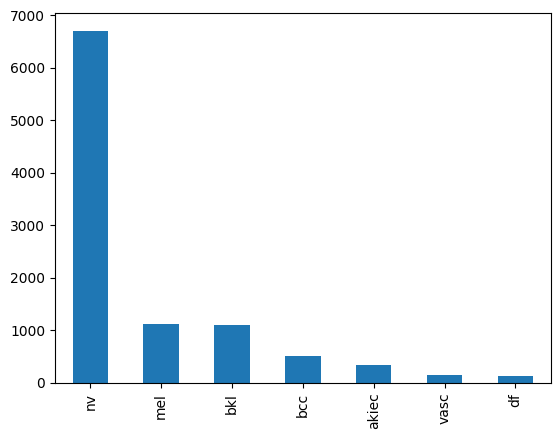

In [39]:
metadata_df["dx"].value_counts().plot(kind="bar")

### Weighted Loss Function
We chose to deal with the unbalanced dataset by using a weighted loss function.
We tried two different options for weights:


1.   **Refined weights** - each weight is exactly negatively proportionate to the class size:


```
akiec_weight = (1/len(os.listdir(train_dir+"akiec"))) * (num_of_train_files / 7)
bcc_weight = (1/len(os.listdir(train_dir+"bcc"))) * (num_of_train_files / 7)
bkl_weight = (1/len(os.listdir(train_dir+"bkl"))) * (num_of_train_files / 7)
df_weight = (1/len(os.listdir(train_dir+"df"))) * (num_of_train_files / 7)
mel_weight = (1/len(os.listdir(train_dir+"mel"))) * (num_of_train_files / 7)
nv_weight = (1/len(os.listdir(train_dir+"nv"))) * (num_of_train_files / 7)
vasc_weight = (1/len(os.listdir(train_dir+"vasc"))) * (num_of_train_files / 7)
```




2.  **Unrefined weights** - Gave slightly higher weights just to bkl and mel, as they are relatively big classes but not as big as nv:


```
akiec_weight = 1
bcc_weight = 1
bkl_weight = 3
df_weight = 1
mel_weight = 3
nv_weight = 1
vasc_weight = 1
```
The results are pretty much comparable but we chose the first option as it yielded slightly better f1 scores.






In [40]:
akiec_weight = (1/len(os.listdir(train_dir+"akiec"))) * (num_of_train_files / 7)
bcc_weight = (1/len(os.listdir(train_dir+"bcc"))) * (num_of_train_files / 7)
bkl_weight = (1/len(os.listdir(train_dir+"bkl"))) * (num_of_train_files / 7)
df_weight = (1/len(os.listdir(train_dir+"df"))) * (num_of_train_files / 7)
mel_weight = (1/len(os.listdir(train_dir+"mel"))) * (num_of_train_files / 7)
nv_weight = (1/len(os.listdir(train_dir+"nv"))) * (num_of_train_files / 7)
vasc_weight = (1/len(os.listdir(train_dir+"vasc"))) * (num_of_train_files / 7)

In [41]:
print(akiec_weight)
print(bcc_weight)
print(bkl_weight)
print(df_weight)
print(mel_weight)
print(nv_weight)
print(vasc_weight)

4.158844765342961
2.789346246973366
1.2427184466019416
12.65934065934066
1.2842809364548495
0.21524663677130046
10.766355140186915


In [42]:
class_weights = {
    0:akiec_weight,
    1:bcc_weight,
    2:bkl_weight,
    3:df_weight,
    4:mel_weight,
    5:nv_weight,
    6:vasc_weight
}

## Defining the model
We will train a network, using imagenet weights as a base but leaving all weights trainable.

In HW3, we chose VGG as a base model. Here, we tried both VGG and a newer architecture: ConvNeXtBase.  We used the ConvNeXtBase architechture as it yielded more superior results.

In [43]:
pre_trained_model = tf.keras.applications.convnext.ConvNeXtBase(input_shape=(150, 200,3), include_top=False, weights="imagenet")

for i in range(len(pre_trained_model.layers)):
  pre_trained_model.layers[i].trainable = True

model = pre_trained_model.output

model = GlobalMaxPooling2D()(model)
model = Dense(64, activation='relu')(model)

model = Dense(7, activation='softmax')(model) # Because there are 7 classes
model = Model(inputs=pre_trained_model.input,
              outputs=model)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

350926856/350926856 [==============================] - 1s 0us/step


In [44]:
# @title Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 200, 3)]        0         []                            
                                                                                                  
 convnext_base_prestem_norm  (None, 150, 200, 3)          0         ['input_1[0][0]']             
 alization (Normalization)                                                                        
                                                                                                  
 convnext_base_stem (Sequen  (None, 37, 50, 128)          6528      ['convnext_base_prestem_normal
 tial)                                                              ization[0][0]']               
                                                                                              

### Run the model

In [45]:
def run_model(model, train_data, valid_data):
  earlystop = EarlyStopping(monitor='val_accuracy',
                            patience=5,
                            mode='auto',
                            verbose=1)

  #reduce learning rate
  reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                                factor = 0.3,
                                patience = 2,
                                min_delta = 0.001,
                                mode='auto',
                                verbose=1)

  #train the model
  history = model.fit(train_data,
                      epochs = 30,
                      validation_data=valid_data,
                      class_weight=class_weights,
                      verbose=1,
                      callbacks=[earlystop,reduce_lr])
  return history

In [46]:
#training_history = run_model(model, train_data, validation_data)

#### Save model for future use

In [47]:
#model.save(source_path+"convnext_classification_model_refined_class_weights_100923.keras")

If already trained - load model

In [48]:
model.load_weights(source_path+"convnext_classification_model_refined_class_weights_100923.keras")

In [49]:
# @title Evaluate the Model
def evaluate_model(history):
  fig , ax = plt.subplots(1,2)
  fig.set_size_inches(20, 8)

  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']

  epochs = range(1, len(train_acc) + 1)

  ax[0].plot(epochs , train_acc , 'g-o' , label = 'Training Accuracy')
  ax[0].plot(epochs , val_acc , 'y-o' , label = 'Validation Accuracy')
  ax[0].set_title('Model Training & Validation Accuracy')
  ax[0].legend(loc = 'lower right')
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
  ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
  ax[1].set_title('Model Training & Validation & Loss')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Loss")

  plt.show()
#evaluate_model(training_history)

## Multiclass evaluation


### Classification Report

In [50]:
def do_classification_report(model):
  y_pred_prob = model.predict(test_data)
  y_pred = np.argmax(y_pred_prob, axis=1)

  y_true = test_data.classes
  y_test = to_categorical(y_true)

  report = classification_report(y_true, y_pred, target_names=target_names)
  print("\nClassification Report:")
  print(report)
  return y_true ,y_pred_prob,  y_pred, y_test

In [51]:
y_true ,y_pred_prob,  y_pred, y_test = do_classification_report(model)
y_true_for_later_use = y_true

31/31 [==============================] - 29s 411ms/step

Classification Report:
              precision    recall  f1-score   support

       akiec       0.80      0.40      0.53        20
         bcc       0.82      0.82      0.82        40
         bkl       0.54      0.92      0.69        93
          df       0.62      0.62      0.62        13
         mel       0.52      0.62      0.56       105
          nv       0.95      0.84      0.89       681
        vasc       0.93      0.88      0.90        16

    accuracy                           0.82       968
   macro avg       0.74      0.73      0.72       968
weighted avg       0.85      0.82      0.82       968



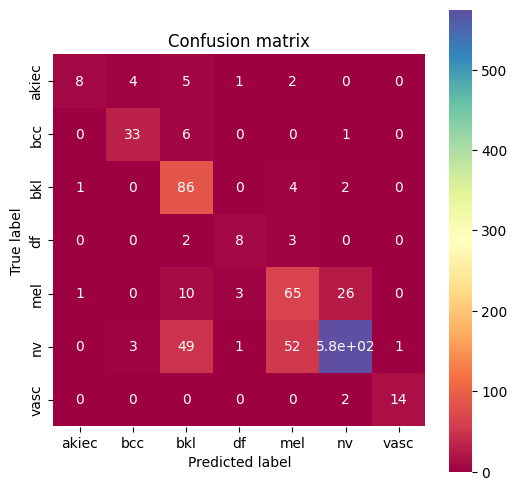

In [52]:
# @title Confusion matrix
def do_cm(y_true , y_pred):
  cm = confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(6,6))
  sns.heatmap(cm, annot=True, square=True, cmap='Spectral',
              xticklabels=target_names, yticklabels=target_names)
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title('Confusion matrix')
  plt.show()

do_cm(y_true , y_pred)

The ROC AUC of akiec is: 0.9706751054852321
The ROC AUC of bcc is: 0.9923221982758621
The ROC AUC of bkl is: 0.9688356374807988
The ROC AUC of df is: 0.9726943213854209
The ROC AUC of mel is: 0.9264691276278761
The ROC AUC of nv is: 0.9475407655272273
The ROC AUC of vasc is: 0.9902179621848739


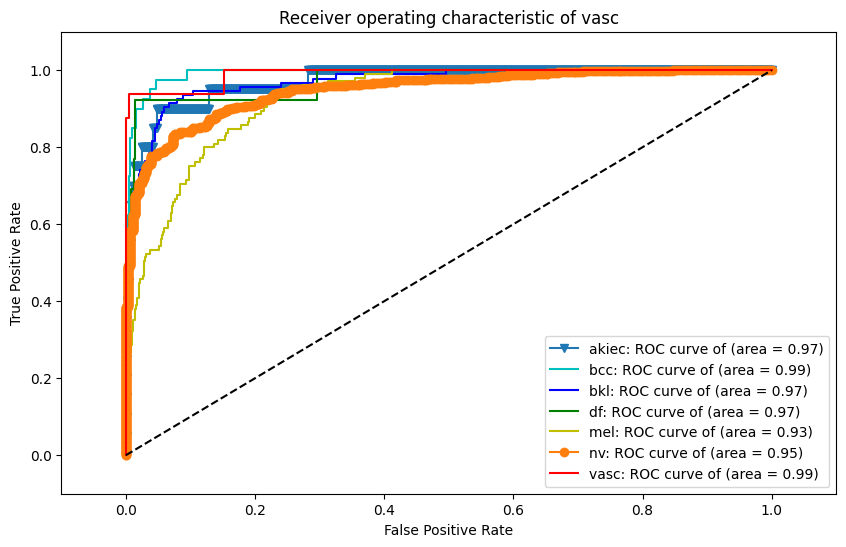

In [53]:
# @title ROC Curve
from sklearn.metrics import roc_auc_score

def do_roc_curve(y_test , y_pred_prob):
  fpr = {}
  tpr = {}
  roc_auc = {}
  for i in range(7):
      r = roc_auc_score(y_test[:, i], y_pred_prob[:, i])
      print("The ROC AUC of "+target_names[i]+" is: "+str(r))
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i], drop_intermediate=False)
      roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure(figsize=(10, 6))
  plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
  plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
  plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
  plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
  plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
  plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
  plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])


  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([-0.1, 1.1])
  plt.ylim([-0.1, 1.1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic of %s'%target_names[i])
  plt.legend(loc="lower right")
  plt.show()

do_roc_curve(y_test , y_pred_prob)

# **Adding Test-Time-Augmentation**
A common way of improving accuracy builds on the artificial increase of the training set by using different augmentation techniques. A less common way relies on test-time augmentation (TTA) which yields transformed versions of the image for prediction and the results are merged.

In previous works, It has been shown that even if only simple test-time augmentations (such as rotation or flipping and proper merging methods) are applied, TTA can significantly improve prediction accuracy.

We can define a TTA by using an ImageDataGenerator: show the model the randomly modified images 10 times, get the prediction for each, and take the average.

In [54]:
def do_tta(tta_steps = 15):
  test_datagen = ImageDataGenerator(rotation_range=180,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  preprocessing_function=preprocess_input)

  predictions = []

  for i in range(tta_steps):
      preds = model.predict(test_datagen.flow_from_dataframe(dataframe= preprocessed_test,
                                                             x_col='filepath',
                                                             y_col='dx',
                                                             target_size=img_resized_size,
                                                             shuffle=False))
      predictions.append(preds)

  y_pred_prob_tta = np.mean(predictions, axis=0)
  y_pred_tta = np.argmax(y_pred_prob_tta, axis=1)

  return y_pred_prob_tta , y_pred_tta



y_pred_prob_tta_no_metadata , y_pred_tta_no_metadata = do_tta()

Found 968 validated image filenames belonging to 7 classes.
31/31 [==============================] - 13s 402ms/step
Found 968 validated image filenames belonging to 7 classes.
31/31 [==============================] - 13s 402ms/step
Found 968 validated image filenames belonging to 7 classes.
31/31 [==============================] - 13s 404ms/step
Found 968 validated image filenames belonging to 7 classes.
31/31 [==============================] - 13s 411ms/step
Found 968 validated image filenames belonging to 7 classes.
31/31 [==============================] - 13s 399ms/step
Found 968 validated image filenames belonging to 7 classes.
31/31 [==============================] - 13s 402ms/step
Found 968 validated image filenames belonging to 7 classes.
31/31 [==============================] - 13s 414ms/step
Found 968 validated image filenames belonging to 7 classes.
31/31 [==============================] - 13s 402ms/step
Found 968 validated image filenames belonging to 7 classes.
31/31 [=====

In [55]:
# @title Classification Report

def do_tta_class_report(y_pred_tta):
  report = classification_report(y_true, y_pred_tta, target_names=target_names)
  print("\nClassification Report:")
  print(report)

do_tta_class_report(y_pred_tta_no_metadata)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.62      0.65      0.63        20
         bcc       0.80      0.93      0.86        40
         bkl       0.71      0.88      0.78        93
          df       0.80      0.62      0.70        13
         mel       0.55      0.77      0.64       105
          nv       0.97      0.86      0.91       681
        vasc       0.78      0.88      0.82        16

    accuracy                           0.85       968
   macro avg       0.75      0.80      0.76       968
weighted avg       0.88      0.85      0.86       968



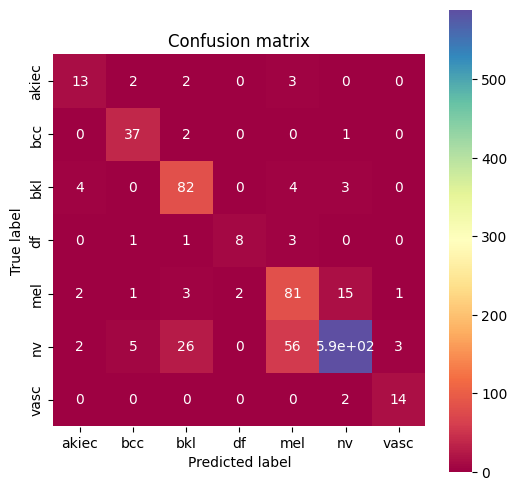

In [56]:
# @title Confusion Matrix
def do_tta_cm(y_pred_tta):
  cm = confusion_matrix(y_true, y_pred_tta) #y_test is true label , Y_pred is predicted

  plt.figure(figsize=(6,6))
  sns.heatmap(cm, annot=True, square=True, cmap='Spectral',
              xticklabels=target_names, yticklabels=target_names)
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title('Confusion matrix')
  plt.show()

do_tta_cm(y_pred_tta_no_metadata)

The ROC AUC of akiec is: 0.9761075949367088
The ROC AUC of bcc is: 0.9953663793103449
The ROC AUC of bkl is: 0.9780399385560675
The ROC AUC of df is: 0.9904953685058396
The ROC AUC of mel is: 0.9438944987033051
The ROC AUC of nv is: 0.9609664000982364
The ROC AUC of vasc is: 0.9940257352941176


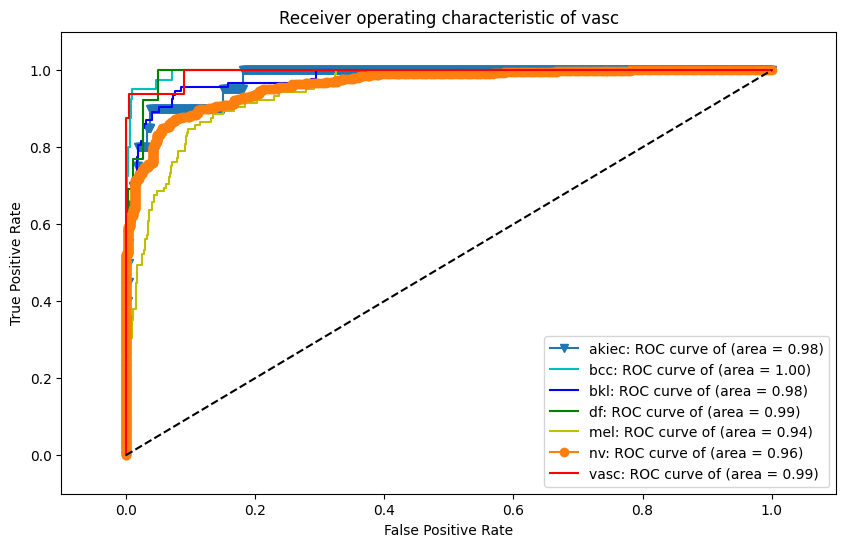

In [57]:
# @title ROC Curve

def do_tta_roc_curve(y_test , y_pred_prob_tta):
  plt.figure(figsize=(10, 6))

  fpr = {}
  tpr = {}
  roc_auc = {}
  for i in range(7):
      r = roc_auc_score(y_test[:, i], y_pred_prob_tta[:, i])
      print("The ROC AUC of "+target_names[i]+" is: "+str(r))
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob_tta[:, i], drop_intermediate=False)
      roc_auc[i] = auc(fpr[i], tpr[i])

  plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
  plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
  plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
  plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
  plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
  plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
  plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])


  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([-0.1, 1.1])
  plt.ylim([-0.1, 1.1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic of %s'%target_names[i])
  plt.legend(loc="lower right")
  plt.show()

do_tta_roc_curve(y_test , y_pred_prob_tta_no_metadata)

The test time augmentation improved the accuracy by 3% and the confusion matrix and ROC AUC is better for most classes.
The most impressive part about TTA is the fact that it does not require retraining a model.

# **Transfer learning model**
We tried two different transfer learning models:


*   **Train last block of last stage** - This includes 9 layers.
*   **Train whole last stage** - This includes 25 layers.


### **Train last 9 layers:**

In [58]:
pre_trained_model = tf.keras.applications.convnext.ConvNeXtBase(input_shape=(150, 200,3), include_top=False, weights="imagenet")
num_of_trainable = 9

for i in range(len(pre_trained_model.layers)):
  if i < len(pre_trained_model.layers) - num_of_trainable:
    pre_trained_model.layers[i].trainable = False
  else:
    pre_trained_model.layers[i].trainable = True

transfer_learning_model = pre_trained_model.output

transfer_learning_model = GlobalMaxPooling2D()(transfer_learning_model)
transfer_learning_model = Dense(64, activation='relu')(transfer_learning_model)

transfer_learning_model = Dense(7, activation='softmax')(transfer_learning_model) # Because there are 7 classes
transfer_learning_model = Model(inputs=pre_trained_model.input,
              outputs=transfer_learning_model)

transfer_learning_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

transfer_learning_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 200, 3)]        0         []                            
                                                                                                  
 convnext_base_prestem_norm  (None, 150, 200, 3)          0         ['input_2[0][0]']             
 alization (Normalization)                                                                        
                                                                                                  
 convnext_base_stem (Sequen  (None, 37, 50, 128)          6528      ['convnext_base_prestem_normal
 tial)                                                              ization[0][0]']               
                                                                                            

In [59]:
#training_history_transfer_learning = run_model(transfer_learning_model, train_data, validation_data)
#evaluate_model(training_history_transfer_learning)

In [60]:
#transfer_learning_model.save(source_path+"convnext_transfer_learning_train_last_block_only_9_layers.keras")
transfer_learning_model.load_weights(source_path+"convnext_transfer_learning_train_last_block_only_9_layers.keras")

In [61]:
# @title Classification Report
y_pred_prob_tf1 = transfer_learning_model.predict(test_data)
y_pred_tf1 = np.argmax(y_pred_prob_tf1, axis=1)


report = classification_report(y_true, y_pred_tf1, target_names=target_names)
print("\nClassification Report:")
print(report)

31/31 [==============================] - 19s 398ms/step

Classification Report:
              precision    recall  f1-score   support

       akiec       0.43      0.15      0.22        20
         bcc       0.54      0.35      0.42        40
         bkl       0.44      0.57      0.50        93
          df       0.12      0.62      0.20        13
         mel       0.35      0.53      0.42       105
          nv       0.92      0.76      0.83       681
        vasc       0.61      0.88      0.72        16

    accuracy                           0.69       968
   macro avg       0.49      0.55      0.47       968
weighted avg       0.77      0.69      0.72       968



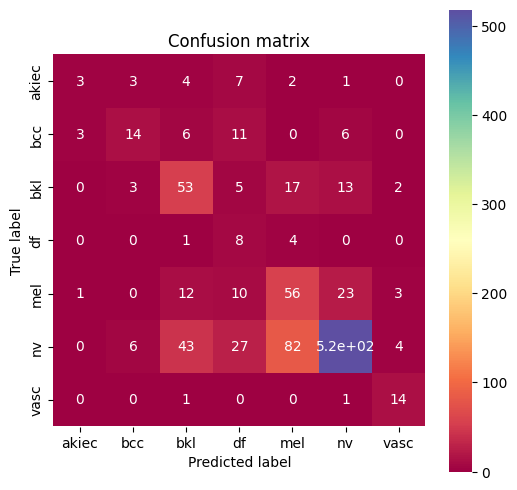

In [62]:
# @title Confusion matrix

cm = confusion_matrix(y_true, y_pred_tf1)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, square=True, cmap='Spectral',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

### **Train last 25 layers:**

In [63]:
pre_trained_model = tf.keras.applications.convnext.ConvNeXtBase(input_shape=(150, 200,3), include_top=False, weights="imagenet")
num_of_trainable = 25
for i in range(len(pre_trained_model.layers)):
  if i < len(pre_trained_model.layers) - num_of_trainable:
    pre_trained_model.layers[i].trainable = False
  else:
    pre_trained_model.layers[i].trainable = True

transfer_learning_model_2 = pre_trained_model.output

transfer_learning_model_2 = GlobalMaxPooling2D()(transfer_learning_model_2)
transfer_learning_model_2 = Dense(64, activation='relu')(transfer_learning_model_2)

transfer_learning_model_2 = Dense(7, activation='softmax')(transfer_learning_model_2) # Because there are 7 classes
transfer_learning_model_2 = Model(inputs=pre_trained_model.input,
              outputs=transfer_learning_model_2)

transfer_learning_model_2.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

transfer_learning_model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 150, 200, 3)]        0         []                            
                                                                                                  
 convnext_base_prestem_norm  (None, 150, 200, 3)          0         ['input_3[0][0]']             
 alization (Normalization)                                                                        
                                                                                                  
 convnext_base_stem (Sequen  (None, 37, 50, 128)          6528      ['convnext_base_prestem_normal
 tial)                                                              ization[0][0]']               
                                                                                            

In [64]:
# training_history_transfer_learning_2 = run_model(transfer_learning_model_2, train_data, validation_data)
# evaluate_model(training_history_transfer_learning_2)

In [65]:
#transfer_learning_model_2.save(source_path+"convnext_transfer_learning_train_whole_last_stage_25_layers.keras")
transfer_learning_model_2.load_weights(source_path+"convnext_transfer_learning_train_whole_last_stage_25_layers.keras")

In [66]:
# @title Classification Report
y_pred_prob_tf2 = transfer_learning_model_2.predict(test_data)
y_pred_tf2 = np.argmax(y_pred_prob_tf2, axis=1)


report = classification_report(y_true, y_pred_tf2, target_names=target_names)
print("\nClassification Report:")
print(report)

31/31 [==============================] - 19s 402ms/step

Classification Report:
              precision    recall  f1-score   support

       akiec       0.50      0.35      0.41        20
         bcc       0.58      0.38      0.45        40
         bkl       0.45      0.53      0.49        93
          df       0.10      0.46      0.17        13
         mel       0.28      0.60      0.38       105
          nv       0.93      0.71      0.81       681
        vasc       0.82      0.88      0.85        16

    accuracy                           0.66       968
   macro avg       0.52      0.56      0.51       968
weighted avg       0.78      0.66      0.70       968



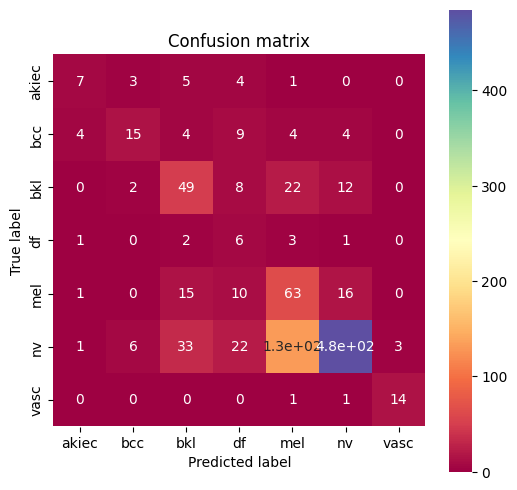

In [67]:
# @title Confusion matrix

cm = confusion_matrix(y_true, y_pred_tf2)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, square=True, cmap='Spectral',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

# **Adding the metadata to the classification model**
After using a simple model to classify the pictures, and improving the results with TTA, we will check if we can further improve the model by adding the use of the metadata we preprocessed earlier.

We will base the image classifying architechture on the best architecthure from the previous parts: training with all layers trainable, starting with imagenet weights.

Afterwards, we will incorporate the metadata by adding an additional input layer for the metadata, merging the image features with the metadata features before feeding them into additional dense layers for combined feature processing.

We will check effect of adding the metadata on the model and discuss the results.

### **Defining the model**
Our model will have two branches that will thenm be merged. It will recieve both the image and the metadata as input. Therefore, we will need to define a custom data generator in order to load both kinds of data and send them to the correct nodes.

We have to do one-hot encoding for the labels in order to use for our custom data generator.

In [68]:
label_mapping = {"akiec":0,
                 "bcc":1,
                 "bkl":2,
                 "df":3,
                 "mel":4,
                 'nv': 5,
                 "vasc":6
                 }
preprocessed_train["dx_mapped"] = preprocessed_train["dx"].map(label_mapping)
preprocessed_validate["dx_mapped"] = preprocessed_validate["dx"].map(label_mapping)
preprocessed_test["dx_mapped"] = preprocessed_test["dx"].map(label_mapping)

In [69]:
# @title Model Architectrue
# Define image input shape
image_input = tf.keras.layers.Input(shape=(150, 200, 3))

# Define metadata input shape based on the number of metadata features
metadata_input = tf.keras.layers.Input(shape=(X_train_metadata_scaled.shape[1],))  # We have 17

# Existing convolutional base
pre_trained_model = tf.keras.applications.convnext.ConvNeXtBase(input_shape=(150, 200, 3), include_top=False, weights="imagenet")
for i in range(len(pre_trained_model.layers)):
  pre_trained_model.layers[i].trainable = True

# Connect your pre-trained model to the image input
pre_trained_output = pre_trained_model(image_input)

# Add GlobalMaxPooling2D
model_output = GlobalMaxPooling2D()(pre_trained_output)
flatten = tf.keras.layers.Flatten()(model_output)

# Now merge with the metadata input
merged = tf.keras.layers.Concatenate(axis=1)([flatten, metadata_input])
merged = Dense(128, activation='relu')(merged)
merged = Dense(96, activation='relu')(merged)
merged = Dense(64, activation='relu')(merged)
merged_output = Dense(7, activation='softmax')(merged)

# Create the final model with both image and metadata inputs
final_model = Model(inputs=[image_input, metadata_input], outputs=merged_output)

# Compile the final model
final_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [70]:
final_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 150, 200, 3)]        0         []                            
                                                                                                  
 convnext_base (Functional)  (None, 4, 6, 1024)           8756646   ['input_4[0][0]']             
                                                          4                                       
                                                                                                  
 global_max_pooling2d_3 (Gl  (None, 1024)                 0         ['convnext_base[0][0]']       
 obalMaxPooling2D)                                                                                
                                                                                            

### **Defining the Custom Data Generator**
In order to run this model that uses both data and metadata, we will define a custom data generator that will load both the images and the metadata.

We had to reduce the batch size to 32 in order to have enough memory this time.
In addition, we will shuffle the train dataframe.

In [71]:
preprocessed_train_shuffled = preprocessed_train.sample(frac=1).reset_index(drop=True)
preprocessed_train_shuffled

,filepath,age,male,female,abdomen,acral,back,chest,ear,face,foot,genital,hand,lower extremity,neck,scalp,trunk,upper extremity,dx,dx_mapped
0,images/train/bkl/ISIC_0027392.jpg,1.961804,0.931181,-0.920096,-0.332322,-0.029476,-0.527422,-0.21045,-0.071486,-0.291362,-0.178868,-0.069712,-0.0929,-0.511832,-0.13579,-0.117599,-0.399525,2.837341,bkl,2
1,images/train/akiec/ISIC_0031228.jpg,0.778485,0.931181,-0.920096,-0.332322,-0.029476,-0.527422,-0.21045,13.988671,-0.291362,-0.178868,-0.069712,-0.0929,-0.511832,-0.13579,-0.117599,-0.399525,-0.352443,akiec,0
2,images/train/bkl/ISIC_0030607.jpg,1.665975,0.931181,-0.920096,-0.332322,-0.029476,-0.527422,-0.21045,-0.071486,-0.291362,-0.178868,-0.069712,-0.0929,-0.511832,-0.13579,-0.117599,-0.399525,2.837341,bkl,2
3,images/train/nv/ISIC_0028770.jpg,-0.109004,-1.073905,1.086843,-0.332322,-0.029476,-0.527422,-0.21045,-0.071486,-0.291362,-0.178868,-0.069712,-0.0929,1.953767,-0.13579,-0.117599,-0.399525,-0.352443,nv,5
4,images/train/nv/ISIC_0027048.jpg,0.186826,-1.073905,1.086843,-0.332322,-0.029476,-0.527422,-0.21045,-0.071486,-0.291362,-0.178868,-0.069712,-0.0929,1.953767,-0.13579,-0.117599,-0.399525,-0.352443,nv,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8059,images/train/bkl/ISIC_0025345.jpg,1.074315,0.931181,-0.920096,-0.332322,-0.029476,-0.527422,-0.21045,-0.071486,-0.291362,-0.178868,-0.069712,-0.0929,1.953767,-0.13579,-0.117599,-0.399525,-0.352443,bkl,2
8060,images/train/bkl/ISIC_0029135.jpg,1.370145,0.931181,-0.920096,-0.332322,-0.029476,-0.527422,-0.21045,-0.071486,3.432159,-0.178868,-0.069712,-0.0929,-0.511832,-0.13579,-0.117599,-0.399525,-0.352443,bkl,2
8061,images/train/df/ISIC_0025911.jpg,0.778485,-1.073905,1.086843,-0.332322,-0.029476,-0.527422,-0.21045,-0.071486,-0.291362,-0.178868,-0.069712,-0.0929,1.953767,-0.13579,-0.117599,-0.399525,-0.352443,df,3
8062,images/train/nv/ISIC_0026285.jpg,0.778485,0.931181,-0.920096,3.009130,-0.029476,-0.527422,-0.21045,-0.071486,-0.291362,-0.178868,-0.069712,-0.0929,-0.511832,-0.13579,-0.117599,-0.399525,-0.352443,nv,5


In [72]:
image_augmentation = ImageDataGenerator(
    rotation_range=180,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    vertical_flip=True,
    fill_mode='nearest'
)

image_loading_no_aug = ImageDataGenerator()


In [73]:
class CustomDataGen(keras.utils.Sequence):
    def __init__(self, df, image_gen ,  batch_size , data_type):
        self.num_of_images = len(df),
        self.num_of_classes = df["dx"].nunique()
        self.df = df.copy()
        self.metadata_cols = ['age', 'male', 'female', 'abdomen', 'acral', 'back',
                            'chest', 'ear', 'face', 'foot', 'genital', 'hand',
                            'lower extremity','neck', 'scalp', 'trunk',
                            'upper extremity']
        self.image_gen = image_gen
        self.batch_size = batch_size
        self.data_type = data_type

    def __len__(self):
        return int(np.ceil( float(self.num_of_images[0]) / float(self.batch_size) ))

    def __get_output(self, labels, num_classes):
      return tf.keras.utils.to_categorical(labels, num_classes=self.num_of_classes)

    def __getitem__(self, idx):
        # Get the Batch
        batch_df = self.df.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Get the images from the batch
        image_batch , _ = next(self.image_gen.flow_from_dataframe(
                dataframe = batch_df,
                x_col='filepath',
                y_col='dx',
                target_size=(150, 200),
                batch_size=self.batch_size,
                class_mode='categorical',
                shuffle=False,
                validate_filenames=False))

        # Get the metadata for the batch
        metadata_batch = batch_df[self.metadata_cols]

        # Get the labels for the batch
        batch_y = np.asarray(self.__get_output(batch_df["dx_mapped"], self.num_of_classes))

        return ((image_batch , metadata_batch), batch_y)

    def on_epoch_end(self):
      if self.data_type == "train":
          self.df = self.df.sample(frac=1).reset_index(drop=True)

In [74]:
custom_train_datagen = CustomDataGen(preprocessed_train_shuffled , image_augmentation, 32, data_type = "train")
custom_val_datagen = CustomDataGen(preprocessed_validate , image_loading_no_aug  , 32, data_type = "val")
custom_test_datagen = CustomDataGen(preprocessed_test , image_loading_no_aug  , 32, data_type = "test")

earlystop = EarlyStopping(monitor='val_accuracy',
                            patience=5,
                            mode='auto',
                            restore_best_weights=True,
                            verbose=1)

#reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                                factor = 0.3,
                                patience = 2,
                                min_delta = 0.001,
                                mode='auto',
                                verbose=1)

# history = final_model.fit(custom_train_datagen,
#                           epochs=30,
#                           validation_data = custom_val_datagen,
#                           class_weight = class_weights,
#                           verbose=1,
#                           callbacks=[earlystop , reduce_lr])



In [75]:
#final_model.save(source_path + "final_model_with_metadata.keras")
final_model.load_weights(source_path + "final_model_with_metadata.keras")

# Evaluating the final model

In [76]:
#evaluate_model(history)

In [77]:
# @title Classification Report
y_pred_prob_with_metadata = final_model.predict(custom_test_datagen)
y_pred_with_metadata = np.argmax(y_pred_prob_with_metadata, axis=1)

y_true = preprocessed_test["dx_mapped"].values
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred_with_metadata, target_names=target_names)
print("\nClassification Report:")
print(report)

Found 32 non-validated image filenames belonging to 1 classes.
Found 32 non-validated image filenames belonging to 1 classes.
Found 32 non-validated image filenames belonging to 1 classes.
Found 32 non-validated image filenames belonging to 2 classes.
31/31 [==============================] - 19s 401ms/step

Classification Report:
              precision    recall  f1-score   support

       akiec       1.00      0.45      0.62        20
         bcc       0.85      0.82      0.84        40
         bkl       0.58      0.88      0.70        93
          df       0.70      0.54      0.61        13
         mel       0.60      0.62      0.61       105
          nv       0.94      0.89      0.92       681
        vasc       0.93      0.88      0.90        16

    accuracy                           0.85       968
   macro avg       0.80      0.73      0.74       968
weighted avg       0.86      0.85      0.85       968



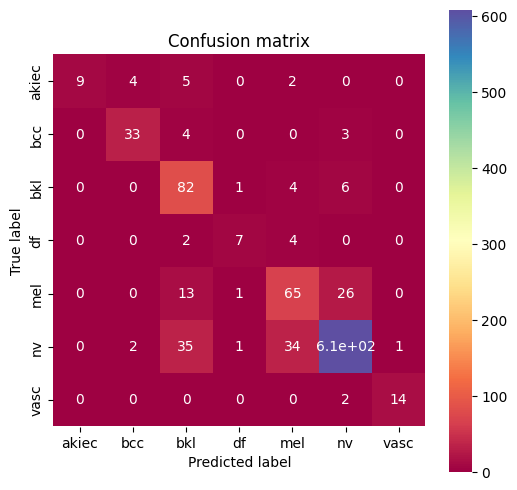

In [78]:
cm = confusion_matrix(y_true, y_pred_with_metadata)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, square=True, cmap='Spectral',
              xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

The ROC AUC of akiec is: 0.9691983122362869
The ROC AUC of bcc is: 0.9936153017241379
The ROC AUC of bkl is: 0.9727557603686636
The ROC AUC of df is: 0.9088199758356826
The ROC AUC of mel is: 0.9383656127572697
The ROC AUC of nv is: 0.9541410203277615
The ROC AUC of vasc is: 0.9896927521008404


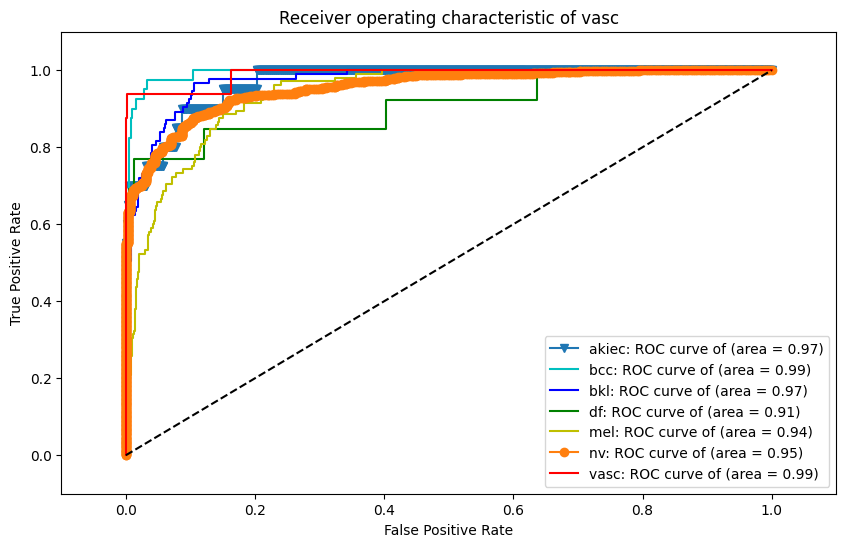

In [79]:

def do_roc_curve():
  fpr = {}
  tpr = {}
  roc_auc = {}
  for i in range(7):
      r = roc_auc_score(y_test[:, i], y_pred_prob_with_metadata[:, i])
      print("The ROC AUC of "+target_names[i]+" is: "+str(r))
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob_with_metadata[:, i], drop_intermediate=False)
      roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure(figsize=(10, 6))
  plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
  plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
  plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
  plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
  plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
  plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
  plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])


  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([-0.1, 1.1])
  plt.ylim([-0.1, 1.1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic of %s'%target_names[i])
  plt.legend(loc="lower right")
  plt.show()

do_roc_curve()

# Adding Test-Time-Augmentation to the Final Model


In [80]:
def do_tta_final_model(tta_steps = 15):
  tta_test_datagen = CustomDataGen(preprocessed_test , image_augmentation  , 32, data_type = "test")

  predictions = []

  for i in range(tta_steps):
      preds = final_model.predict(tta_test_datagen)
      predictions.append(preds)

  y_pred_prob_tta = np.mean(predictions, axis=0)
  y_pred_tta = np.argmax(y_pred_prob_tta, axis=1)

  return y_pred_prob_tta , y_pred_tta


y_pred_prob_tta_with_metadata , y_pred_tta_with_metadata = do_tta_final_model()

Found 32 non-validated image filenames belonging to 1 classes.
Found 32 non-validated image filenames belonging to 1 classes.
Found 32 non-validated image filenames belonging to 1 classes.
31/31 [==============================] - 13s 418ms/step
Found 32 non-validated image filenames belonging to 1 classes.
Found 32 non-validated image filenames belonging to 1 classes.
Found 32 non-validated image filenames belonging to 1 classes.
31/31 [==============================] - 13s 405ms/step
Found 32 non-validated image filenames belonging to 1 classes.
Found 32 non-validated image filenames belonging to 1 classes.
Found 32 non-validated image filenames belonging to 1 classes.
31/31 [==============================] - 13s 403ms/step
Found 32 non-validated image filenames belonging to 1 classes.
Found 32 non-validated image filenames belonging to 1 classes.
Found 32 non-validated image filenames belonging to 1 classes.
31/31 [==============================] - 13s 407ms/step
Found 32 non-validat

In [81]:
# @title Classification Report

do_tta_class_report(y_pred_tta_with_metadata)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.59      0.65      0.62        20
         bcc       0.77      0.93      0.84        40
         bkl       0.78      0.86      0.82        93
          df       0.78      0.54      0.64        13
         mel       0.58      0.77      0.66       105
          nv       0.96      0.89      0.92       681
        vasc       0.83      0.94      0.88        16

    accuracy                           0.86       968
   macro avg       0.76      0.80      0.77       968
weighted avg       0.88      0.86      0.87       968



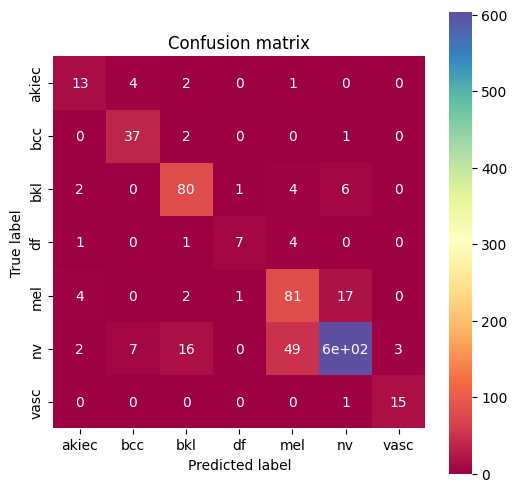

In [82]:
# @title Confusion Matrix
do_tta_cm(y_pred_tta_with_metadata)

The ROC AUC of akiec is: 0.9786392405063291
The ROC AUC of bcc is: 0.9953663793103449
The ROC AUC of bkl is: 0.9872442396313365
The ROC AUC of df is: 0.9710833668948852
The ROC AUC of mel is: 0.9497213485626
The ROC AUC of nv is: 0.9665382431042687
The ROC AUC of vasc is: 0.9948135504201681


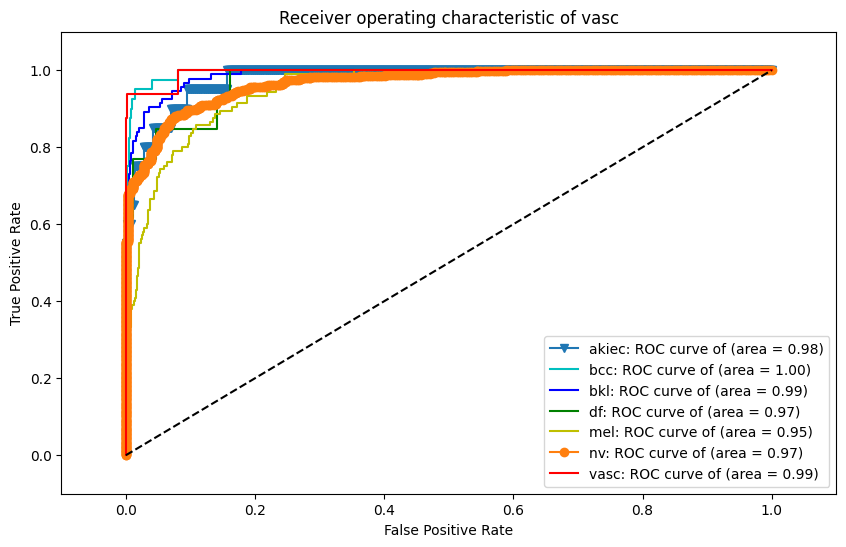

In [83]:
# @title ROC Curve

do_tta_roc_curve(y_test ,y_pred_prob_tta_with_metadata)

# **Analysis: Classification vs Segmentation**

We want to view the segmentation results for the misclassified samples and see if there is a correlation between missclassification and poor segmentation results.

We will use the model without metadata, as the segmentation model doesn't use metadata either.

In [84]:
preprocessed_test["classified_correctly_no_metadata"] = y_pred_tta_no_metadata == y_true
preprocessed_test["classified_correctly_with_metadata"] = y_pred_tta_with_metadata == y_true
preprocessed_test["classification_no_metadata"] = y_pred_tta_no_metadata
preprocessed_test["classification_with_metadata"] =y_pred_tta_with_metadata

In [85]:
segmentation_res = pd.read_csv(source_path+"test_set_segmented_model_final.csv", index_col=0)
segmentation_res = segmentation_res[["filepath" , 'jaccard_index' , "jaccard_index_improved"]]

In [86]:
test_results = preprocessed_test.merge(segmentation_res , how="left", on="filepath")
true_false_to_ints_mapping = {True: 1, False: 0}
test_results['classified_correctly_no_metadata'] = test_results['classified_correctly_no_metadata'].map(true_false_to_ints_mapping)
test_results['classified_correctly_with_metadata'] = test_results['classified_correctly_with_metadata'].map(true_false_to_ints_mapping)
test_results

,filepath,age,male,female,abdomen,acral,back,chest,ear,face,...,trunk,upper extremity,dx,dx_mapped,classified_correctly_no_metadata,classified_correctly_with_metadata,classification_no_metadata,classification_with_metadata,jaccard_index,jaccard_index_improved
0,images/test/bkl/ISIC_0027828.jpg,-0.700664,0.931181,-0.920096,-0.332322,-0.029476,-0.527422,-0.21045,-0.071486,-0.291362,...,-0.399525,2.837341,bkl,2,1,1,2,2,0.918308,0.918308
1,images/test/bkl/ISIC_0029291.jpg,-0.700664,0.931181,-0.920096,-0.332322,-0.029476,-0.527422,-0.21045,-0.071486,-0.291362,...,-0.399525,2.837341,bkl,2,1,0,2,5,0.925620,0.925620
2,images/test/bkl/ISIC_0030698.jpg,-0.700664,0.931181,-0.920096,-0.332322,-0.029476,1.896015,-0.21045,-0.071486,-0.291362,...,-0.399525,-0.352443,bkl,2,1,1,2,2,0.924127,0.924127
3,images/test/bkl/ISIC_0025567.jpg,-0.700664,0.931181,-0.920096,-0.332322,-0.029476,1.896015,-0.21045,-0.071486,-0.291362,...,-0.399525,-0.352443,bkl,2,1,1,2,2,0.849626,0.849626
4,images/test/bkl/ISIC_0030377.jpg,1.074315,0.931181,-0.920096,-0.332322,-0.029476,1.896015,-0.21045,-0.071486,-0.291362,...,-0.399525,-0.352443,bkl,2,1,1,2,2,0.111428,0.111428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,images/test/akiec/ISIC_0033295.jpg,1.074315,0.931181,-0.920096,-0.332322,-0.029476,-0.527422,-0.21045,-0.071486,-0.291362,...,-0.399525,-0.352443,akiec,0,1,1,0,0,0.346976,0.346976
964,images/test/akiec/ISIC_0024925.jpg,1.370145,0.931181,-0.920096,3.009130,-0.029476,-0.527422,-0.21045,-0.071486,-0.291362,...,-0.399525,-0.352443,akiec,0,0,0,1,1,0.841069,0.841069
965,images/test/akiec/ISIC_0024654.jpg,1.370145,-1.073905,1.086843,-0.332322,-0.029476,-0.527422,-0.21045,-0.071486,-0.291362,...,-0.399525,-0.352443,akiec,0,0,0,2,2,0.053711,0.944617
966,images/test/akiec/ISIC_0032947.jpg,1.074315,0.931181,-0.920096,-0.332322,-0.029476,-0.527422,-0.21045,-0.071486,-0.291362,...,-0.399525,-0.352443,akiec,0,1,1,0,0,0.302178,0.302178


Let's check correlation between correct classification and the jaccard index. We will do this with a simple linear regression between "classified_correctly" and "jaccard_index", running an f-test for the p-value.

In [87]:
def get_pval_linear_regression(x , y , do_print_res=False):

    if len(x) != len(y):
        print("ERROR in lengths of x , y")
        return -1

    else:

        x = x.reshape(-1, 1)
        y = y.reshape(-1, 1)

        # Run test and get pvalue:
        p_val = f_regression(x, y.ravel())[1][0]

        simple_linear_regression = LinearRegression()
        simple_linear_regression.fit(x, y)
        slope =  simple_linear_regression.coef_[0][0]
        intercept = simple_linear_regression.intercept_[0]

        predictions = simple_linear_regression.predict(x)
        plt.scatter(x, y, color='blue', label='Data')
        plt.plot(x, predictions, color='red', label='Linear Regression')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Linear Regression')
        plt.legend()
        plt.show()


        if do_print_res==True:
          print_res(p_val , slope , intercept)

        return p_val , slope , intercept

In [88]:
def print_res(pvalue , slope , intercept):
    print("Regression and F-test results:")
    print("P-value= ", pvalue)
    print("Slope= ", slope)
    print("Intercept= ", intercept)

### **No metadata model**

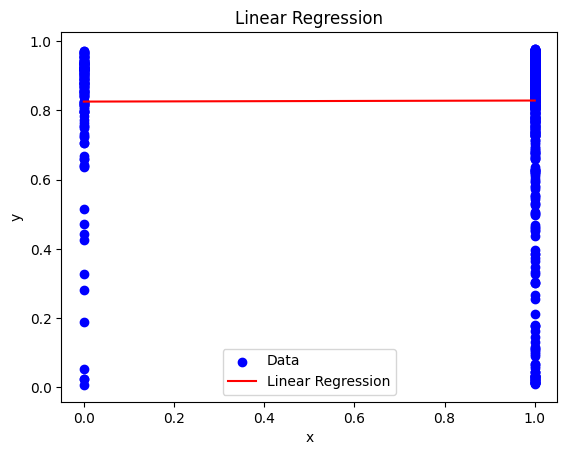

Regression and F-test results:
P-value=  0.8733214840517283
Slope=  0.003081581794228686
Intercept=  0.825712501861111


In [89]:
x = test_results["classified_correctly_no_metadata"].values
y = test_results["jaccard_index"].values

pvalue , slope , intercept = get_pval_linear_regression(x, y)
print_res(pvalue , slope , intercept)

### **Metadata model**

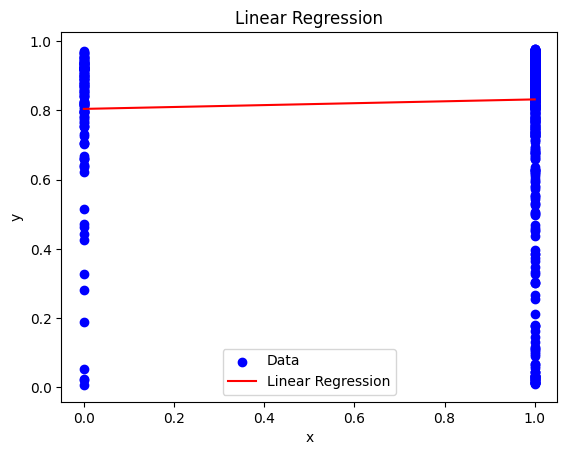

Regression and F-test results:
P-value=  0.17213157123616937
Slope=  0.027439057549481494
Intercept=  0.8046099525114503


In [90]:
x = test_results["classified_correctly_with_metadata"].values
y = test_results["jaccard_index"].values

pvalue , slope , intercept = get_pval_linear_regression(x, y)
print_res(pvalue , slope , intercept)

In [91]:
test_results.to_csv(source_path+"final_pval_test_results.csv")

## Check per class

In [92]:
def print_bold(s):
  print("\033[1m" + s + "\033[0m")



Class name = akiec
Class size = 20


No metadata + regular Jaccard index:


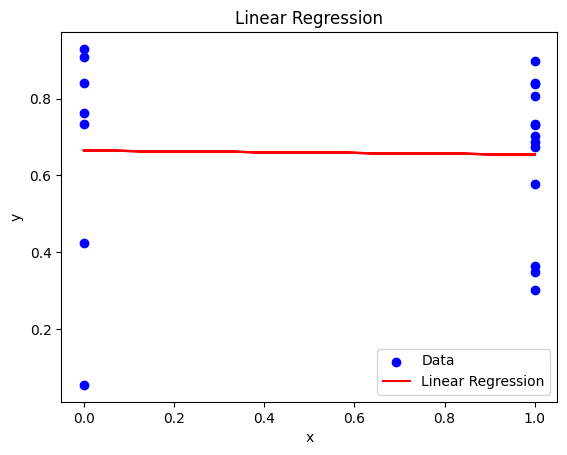

Regression and F-test results:
P-value=  0.9307153275388895
Slope=  -0.010140346197802188
Intercept=  0.6648096654285715
With metadata + regular Jaccard index:


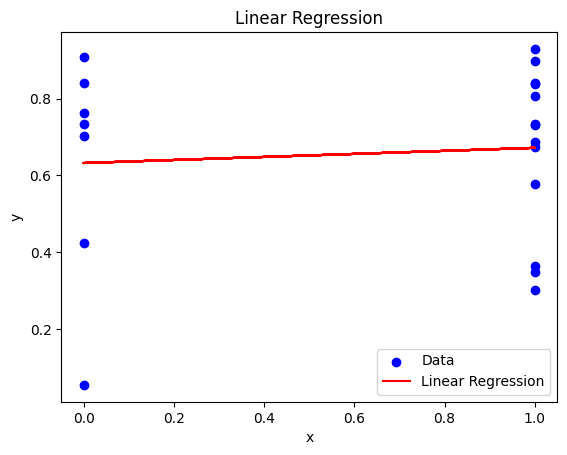

Regression and F-test results:
P-value=  0.7336275358485314
Slope=  0.03962797248351647
Intercept=  0.6324602582857143


Class name = bcc
Class size = 40


No metadata + regular Jaccard index:


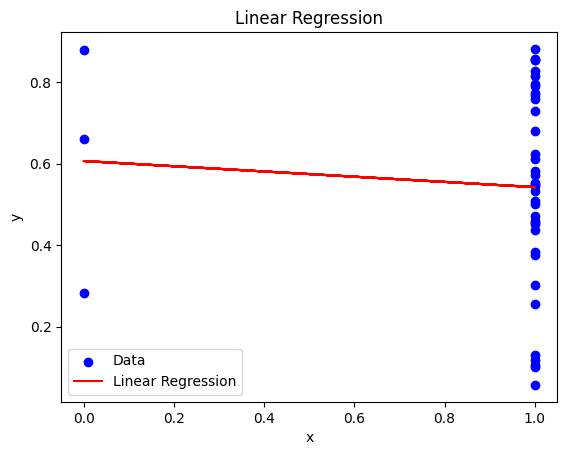

Regression and F-test results:
P-value=  0.6662822516047078
Slope=  -0.06417754893693695
Intercept=  0.6067842466666667
With metadata + regular Jaccard index:


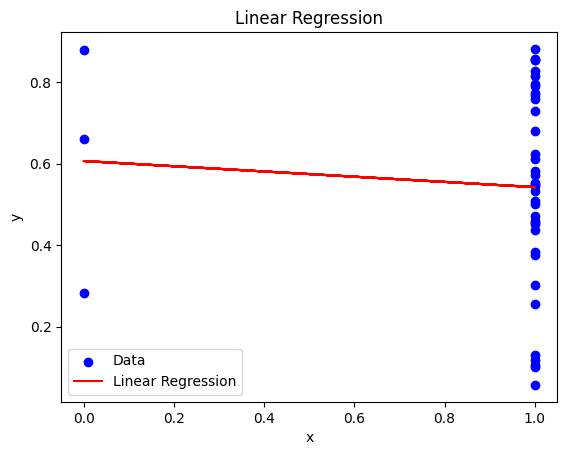

Regression and F-test results:
P-value=  0.6662822516047078
Slope=  -0.06417754893693695
Intercept=  0.6067842466666667


Class name = bkl
Class size = 93


No metadata + regular Jaccard index:


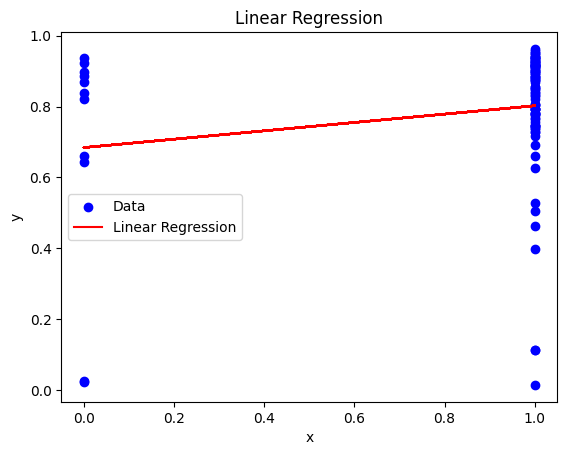

Regression and F-test results:
P-value=  0.07615866991548402
Slope=  0.11801470877937911
Intercept=  0.6842659318181818
With metadata + regular Jaccard index:


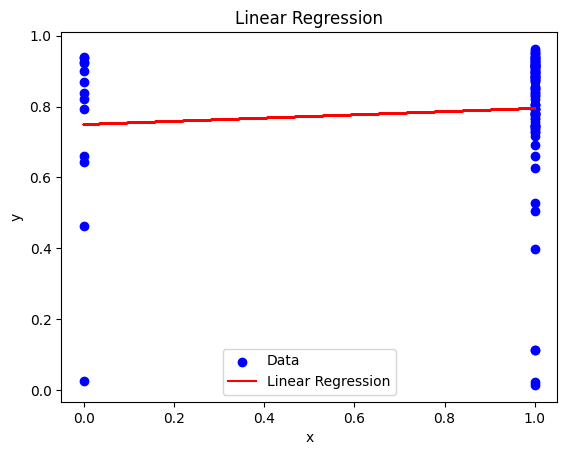

Regression and F-test results:
P-value=  0.4657626352424905
Slope=  0.045530011504807705
Intercept=  0.7491563103076923


Class name = df
Class size = 13


No metadata + regular Jaccard index:


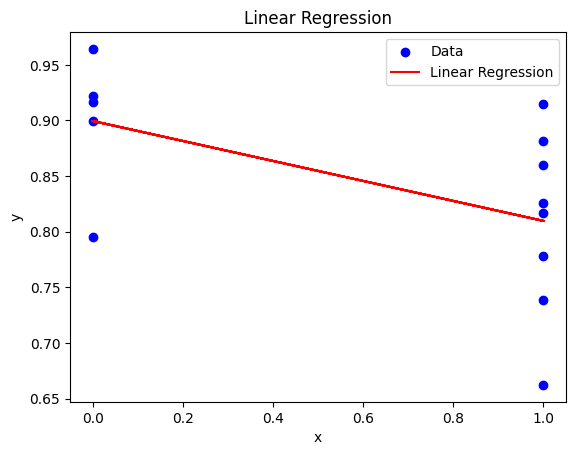

Regression and F-test results:
P-value=  0.06114805322777901
Slope=  -0.08979970025
Intercept=  0.8995760140000001
With metadata + regular Jaccard index:


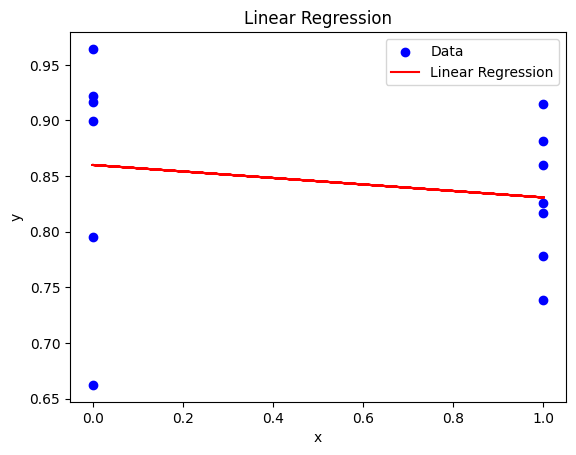

Regression and F-test results:
P-value=  0.5618432891455657
Slope=  -0.02922376476190476
Intercept=  0.8600505333333335


Class name = mel
Class size = 105


No metadata + regular Jaccard index:


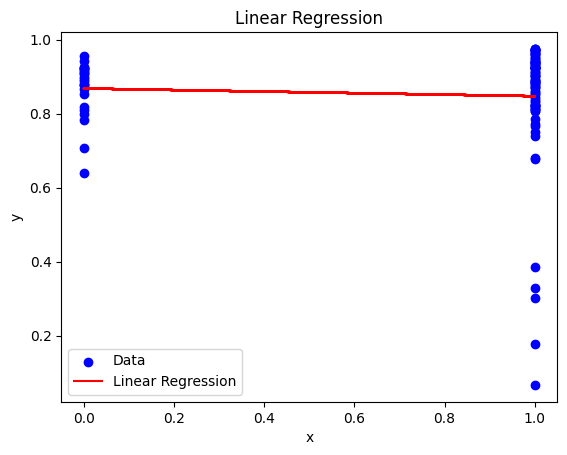

Regression and F-test results:
P-value=  0.5633089190508622
Slope=  -0.02075597030864196
Intercept=  0.8676042216666666
With metadata + regular Jaccard index:


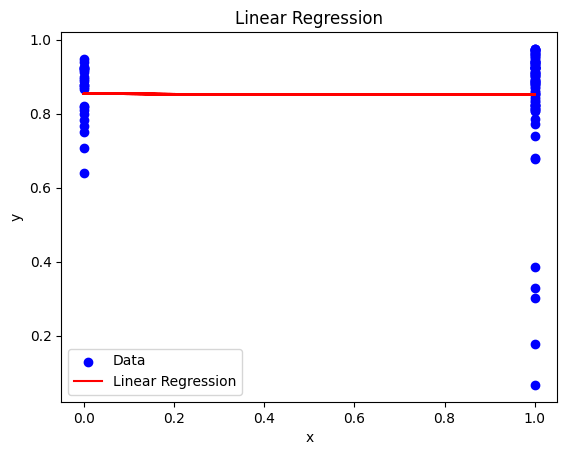

Regression and F-test results:
P-value=  0.9583582819336078
Slope=  -0.0018767310339506064
Intercept=  0.8530402370833333


Class name = nv
Class size = 681


No metadata + regular Jaccard index:


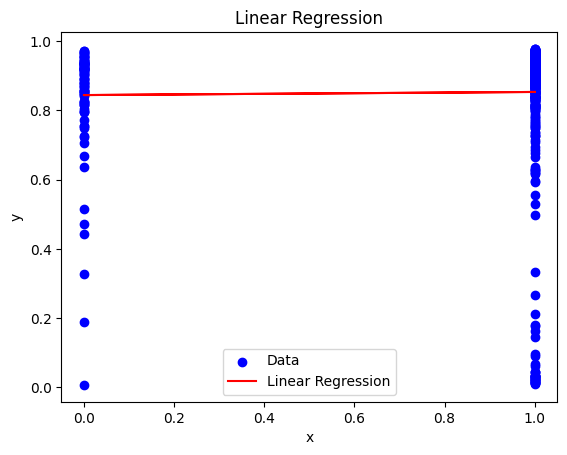

Regression and F-test results:
P-value=  0.6971212531926771
Slope=  0.009029143315604915
Intercept=  0.8445312855434781
With metadata + regular Jaccard index:


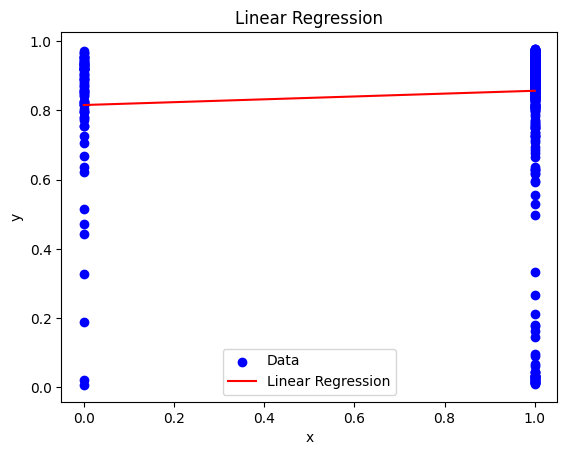

Regression and F-test results:
P-value=  0.09955983321193117
Slope=  0.041203350495162105
Intercept=  0.8157961045064934


Class name = vasc
Class size = 16


No metadata + regular Jaccard index:


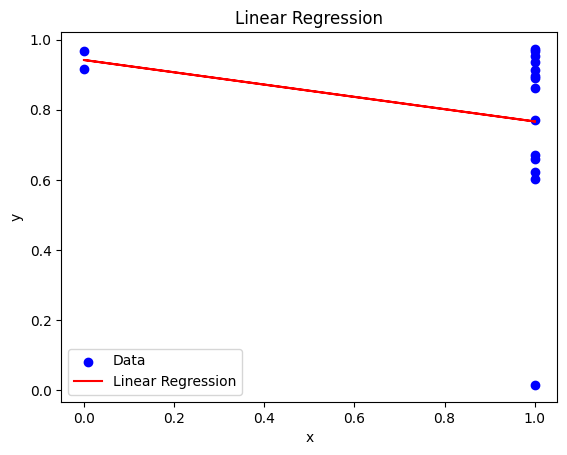

Regression and F-test results:
P-value=  0.3606928641837304
Slope=  -0.1756151965
Intercept=  0.94219748
With metadata + regular Jaccard index:


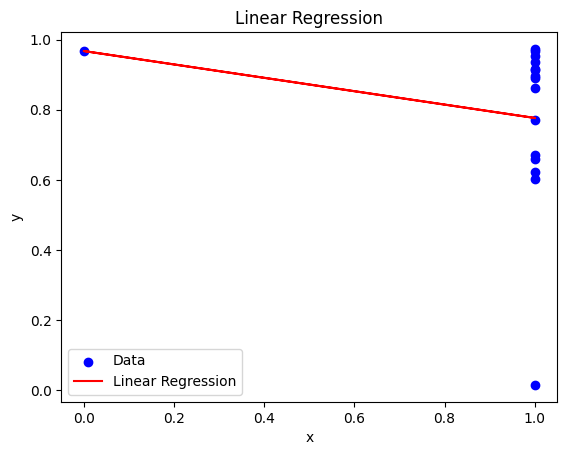

Regression and F-test results:
P-value=  0.4690755138144024
Slope=  -0.1911403487333334
Intercept=  0.9677282600000001


,dx,pval_no_metadata_jaccard_index,pval_with_metadata_jaccard_index,adjusted_pvals_no_metadata,adjusted_pvals_with_metadata
0,akiec,0.930715,0.733628,0.958358,0.855899
1,bcc,0.666282,0.666282,0.855899,0.855899
2,bkl,0.076159,0.465763,0.464613,0.855899
3,df,0.061148,0.561843,0.464613,0.855899
4,mel,0.563309,0.958358,0.855899,0.958358
5,nv,0.697121,0.099560,0.855899,0.464613
6,vasc,0.360693,0.469076,0.855899,0.855899


In [93]:
grouped = test_results.groupby('dx')
results = {'dx': [],
           'pval_no_metadata_jaccard_index': [],
           'pval_with_metadata_jaccard_index': []}


for name, group in grouped:
    print_bold("\n\n"+ "Class name = "+ name)
    print_bold("Class size = "+str(len(group)) +"\n\n")
    x1 = group['classified_correctly_no_metadata'].values
    x2 = group['classified_correctly_with_metadata'].values
    y = group['jaccard_index'].values


    print("No metadata + regular Jaccard index:")
    pval1 = get_pval_linear_regression(x1, y , do_print_res=True)[0]

    print("With metadata + regular Jaccard index:")
    pval2 = get_pval_linear_regression(x2, y, do_print_res=True)[0]

    results["dx"].append(name)
    results["pval_no_metadata_jaccard_index"].append(pval1)
    results["pval_with_metadata_jaccard_index"].append(pval2)

all_pvals = results["pval_no_metadata_jaccard_index"] + results["pval_with_metadata_jaccard_index"]
adjusted_pvals_fdr = statsmodels.stats.multitest.fdrcorrection(all_pvals)[1]

results["adjusted_pvals_no_metadata"] = adjusted_pvals_fdr[:7]
results["adjusted_pvals_with_metadata"] = adjusted_pvals_fdr[7:]


result_df = pd.DataFrame(results)
result_df

# **Interpretability**
Focusing on the no-metadata model, we would like to use GRAD-CAM to see if we can see any hints that would explain the correlation between the jaccard index and correctness of classification.

In [94]:
!wget -nc "https://docs.google.com/uc?export=download&id=1FBr-TtoeRvLzouBfl4yUbLFd0jDgsbJ7" -O gradcam.py --quiet
from gradcam import VizGradCAM

In [95]:
import cv2
from tensorflow.keras.preprocessing.image import img_to_array

In [96]:
test_results_correctly_classified_no_metadata = test_results[test_results["classified_correctly_no_metadata"] == 1]
test_results_missclasified_no_metadata = test_results[test_results["classified_correctly_no_metadata"] == 0]

In [97]:
def plot_class_activation_map(image_pathes):
  for i, path in enumerate(image_pathes):
    tf_img = tf.io.read_file(path)
    tf_img = tf.image.decode_jpeg(tf_img)

    plt.subplot(1, 2, 1)
    plt.imshow(tf_img)
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.grid(False)
    tf_img = tf.image.resize(tf_img , size=(150, 200))

    print("Filename: " , image_pathes[i])
    VizGradCAM(model, img_to_array(tf_img), plot_results=True)
    plt.show()

We will try to look at the GRADCAM results for images with high and low jaccard indexes.

In [98]:
sorted_test_results_correctly_classified_no_metadata = test_results_correctly_classified_no_metadata.sort_values(by="jaccard_index_improved", ascending=False)
sorted_test_results_correctly_classified_no_metadata

,filepath,age,male,female,abdomen,acral,back,chest,ear,face,...,trunk,upper extremity,dx,dx_mapped,classified_correctly_no_metadata,classified_correctly_with_metadata,classification_no_metadata,classification_with_metadata,jaccard_index,jaccard_index_improved
440,images/test/nv/ISIC_0024500.jpg,-0.404834,0.931181,-0.920096,3.009130,-0.029476,-0.527422,-0.21045,-0.071486,-0.291362,...,-0.399525,-0.352443,nv,5,1,1,5,5,0.010335,0.988606
574,images/test/nv/ISIC_0024533.jpg,-0.404834,0.931181,-0.920096,-0.332322,-0.029476,-0.527422,-0.21045,-0.071486,-0.291362,...,-0.399525,-0.352443,nv,5,1,1,5,5,0.012639,0.983619
494,images/test/nv/ISIC_0024335.jpg,-0.404834,-1.073905,1.086843,-0.332322,-0.029476,-0.527422,-0.21045,-0.071486,-0.291362,...,-0.399525,-0.352443,nv,5,1,1,5,5,0.015625,0.983557
360,images/test/nv/ISIC_0024555.jpg,-0.109004,-1.073905,1.086843,-0.332322,-0.029476,-0.527422,-0.21045,-0.071486,-0.291362,...,-0.399525,-0.352443,nv,5,1,1,5,5,0.013308,0.982184
460,images/test/nv/ISIC_0024434.jpg,-0.700664,0.931181,-0.920096,3.009130,-0.029476,-0.527422,-0.21045,-0.071486,-0.291362,...,-0.399525,-0.352443,nv,5,1,1,5,5,0.014987,0.981602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
850,images/test/nv/ISIC_0026034.jpg,0.482655,0.931181,-0.920096,-0.332322,-0.029476,-0.527422,-0.21045,-0.071486,-0.291362,...,-0.399525,-0.352443,nv,5,1,1,5,5,0.146381,0.146381
257,images/test/bcc/ISIC_0029123.jpg,1.665975,0.931181,-0.920096,-0.332322,-0.029476,1.896015,-0.21045,-0.071486,-0.291362,...,-0.399525,-0.352443,bcc,1,1,1,1,1,0.129882,0.129882
258,images/test/bcc/ISIC_0029372.jpg,1.665975,0.931181,-0.920096,-0.332322,-0.029476,1.896015,-0.21045,-0.071486,-0.291362,...,-0.399525,-0.352443,bcc,1,1,1,1,1,0.116939,0.116939
4,images/test/bkl/ISIC_0030377.jpg,1.074315,0.931181,-0.920096,-0.332322,-0.029476,1.896015,-0.21045,-0.071486,-0.291362,...,-0.399525,-0.352443,bkl,2,1,1,2,2,0.111428,0.111428


In [99]:
sorted_test_results_missclasified_no_metadata = test_results_missclasified_no_metadata.sort_values(by="jaccard_index_improved", ascending=False)
sorted_test_results_missclasified_no_metadata

,filepath,age,male,female,abdomen,acral,back,chest,ear,face,...,trunk,upper extremity,dx,dx_mapped,classified_correctly_no_metadata,classified_correctly_with_metadata,classification_no_metadata,classification_with_metadata,jaccard_index,jaccard_index_improved
716,images/test/nv/ISIC_0024344.jpg,1.961804,-1.073905,1.086843,-0.332322,-0.029476,1.896015,-0.210450,-0.071486,-0.291362,...,-0.399525,-0.352443,nv,5,0,0,4,4,0.007333,0.990813
51,images/test/bkl/ISIC_0024612.jpg,1.961804,0.931181,-0.920096,-0.332322,-0.029476,1.896015,-0.210450,-0.071486,-0.291362,...,-0.399525,-0.352443,bkl,2,0,0,4,4,0.024339,0.973725
686,images/test/nv/ISIC_0031160.jpg,-0.996493,-1.073905,1.086843,-0.332322,-0.029476,-0.527422,-0.210450,-0.071486,-0.291362,...,-0.399525,2.837341,nv,5,0,0,4,4,0.972299,0.972299
338,images/test/nv/ISIC_0027333.jpg,-0.700664,0.931181,-0.920096,-0.332322,-0.029476,-0.527422,-0.210450,-0.071486,-0.291362,...,-0.399525,-0.352443,nv,5,0,1,2,5,0.970679,0.970679
805,images/test/nv/ISIC_0027248.jpg,-1.292323,-1.073905,1.086843,3.009130,-0.029476,-0.527422,-0.210450,-0.071486,-0.291362,...,-0.399525,-0.352443,nv,5,0,1,4,5,0.970339,0.970339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,images/test/nv/ISIC_0029794.jpg,-0.109004,-1.073905,1.086843,-0.332322,-0.029476,1.896015,-0.210450,-0.071486,-0.291362,...,-0.399525,-0.352443,nv,5,0,0,1,1,0.442865,0.442865
950,images/test/akiec/ISIC_0024913.jpg,1.961804,0.931181,-0.920096,-0.332322,-0.029476,1.896015,-0.210450,-0.071486,-0.291362,...,-0.399525,-0.352443,akiec,0,0,0,4,1,0.424548,0.424548
877,images/test/nv/ISIC_0028400.jpg,0.778485,0.931181,-0.920096,-0.332322,-0.029476,1.896015,-0.210450,-0.071486,-0.291362,...,-0.399525,-0.352443,nv,5,0,0,1,1,0.329106,0.329106
261,images/test/bcc/ISIC_0030954.jpg,1.961804,0.931181,-0.920096,-0.332322,-0.029476,-0.527422,4.751731,-0.071486,-0.291362,...,-0.399525,-0.352443,bcc,1,0,0,5,5,0.281770,0.281770


In [100]:
thirty_best_jaccard_correctly_classified = sorted_test_results_correctly_classified_no_metadata.filepath.values[:30]
thirty_worst_jaccard_correctly_classified = sorted_test_results_correctly_classified_no_metadata.filepath.values[-30:]

thirty_best_jaccard_misclassified = sorted_test_results_missclasified_no_metadata.filepath.values[:30]
thirty_worst_jaccard_misclassified = sorted_test_results_missclasified_no_metadata.filepath.values[-30:]

## **Interpretability For Correctly Classified Samples**

In [ ]:
plot_class_activation_map(thirty_best_jaccard_correctly_classified)

In [ ]:
plot_class_activation_map(thirty_worst_jaccard_correctly_classified)

## **Interpretability For Misclassified Samples**

In [ ]:
plot_class_activation_map(thirty_best_jaccard_misclassified)

In [ ]:
plot_class_activation_map(thirty_worst_jaccard_misclassified)

## Interpretability by Class

In [ ]:
grouped = test_results.groupby('dx')

for name, group in grouped:
    class_size = len(group)
    print_bold("\n\n"+ "CLASS NAME = "+ str.upper(name))
    print_bold("CLASS SIZE = "+str(class_size) +"\n\n")

    sorted_group = group.sort_values(by="jaccard_index_improved",
                                     ascending=False)


    num_to_show = min(int(0.5 * class_size) , 10)
    best_jaccard_for_class = sorted_group.filepath.values[:num_to_show]
    worst_jaccard_for_class = sorted_group.filepath.values[-1*num_to_show:]

    print_bold("Best Jaccaard for class:")
    plot_class_activation_map(best_jaccard_for_class)
    print_bold("Worst Jaccaard for class:")
    plot_class_activation_map(worst_jaccard_for_class)


